In [116]:
from keras.models import load_model
from keras.preprocessing import image
from keras import models
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt

import cv2

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

**Визуализация промежуточных активаций**

Модель, полученная в предыдущей тетрадке (Simple CNN)

In [4]:
model = load_model('CNN models from chapter 4/cats_vs_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Загрузим изображение, которое не являлось частью обучаюшего набора.

In [5]:
# Windows, home
img_path = r'H:\Datasets\dogs-vs-cats_small\test\cats\cat.1671.jpg'

In [9]:
img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
print('tensor shape before np.expand:', img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis = 0) #add dimension https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html
print('tensor shape after np.expand:', img_tensor.shape)
img_tensor /= 255  # Модель обучалась на данных, которые были обработанны так же 

tensor shape before np.expand: (150, 150, 3)
tensor shape after np.expand: (1, 150, 150, 3)


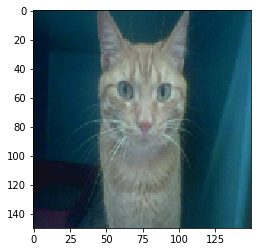

In [12]:
plt.imshow(img_tensor[0])
plt.show()

Для извлечения карт признаков, подлежащих визуализации, создадим модель  Keras, которая принимает пакеты изображений и выводит активации все сверточных и объединяющих слоев.

Пример для одного слоя, одной активации

In [15]:
layers_outputs = [layer.output for layer in model.layers[:8]] #Извлечение выходов 8 верхних слоев
activation_model = models.Model(inputs = model.input, outputs = layers_outputs) # Модель, которая вернет эти выходы с учетом input-а
#Данна модель примечательна тем, что имея всего 1 вход обладает 8-ю выходами

In [20]:
activations = activation_model.predict(img_tensor) # Получаем тензоры активаций для нашего изображения
print(len(activations))
print(activations[0].shape) # Получаем, что у нас 8 карт признаков размером 148х148 с 32 каналами

8
(1, 148, 148, 32)


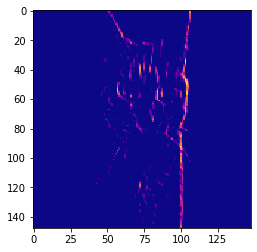

In [41]:
# Визуализируем 4-ый канал 1-ого слоя для примера
plt.imshow(activations[0][0, :, :, 3], cmap = 'plasma')

А теперь соберем полную визуализацию

C:\Users\Grigoriy\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


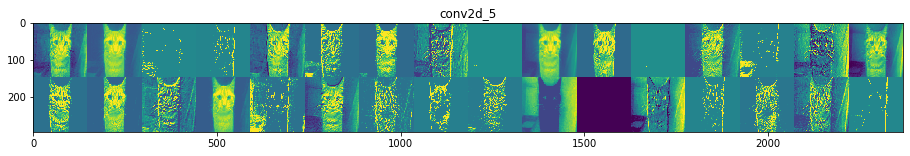

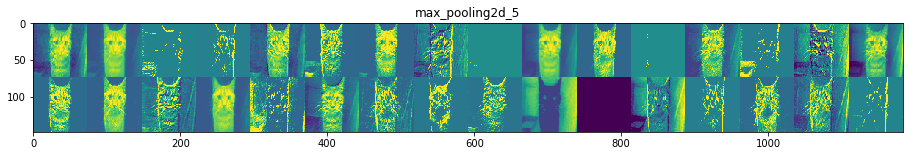

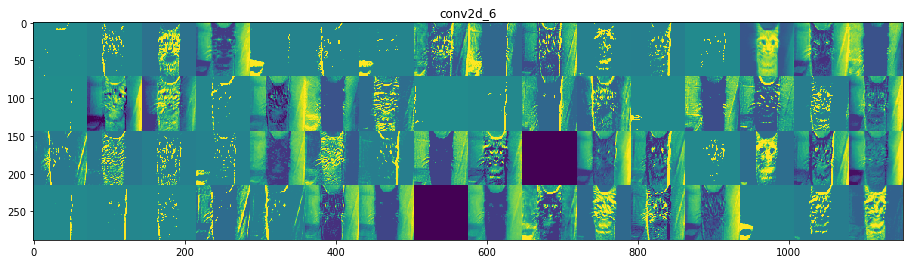

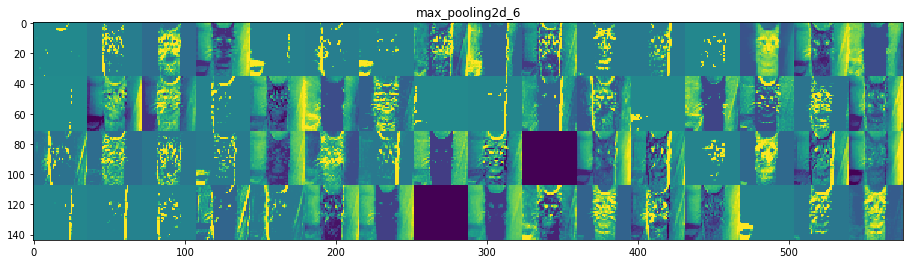

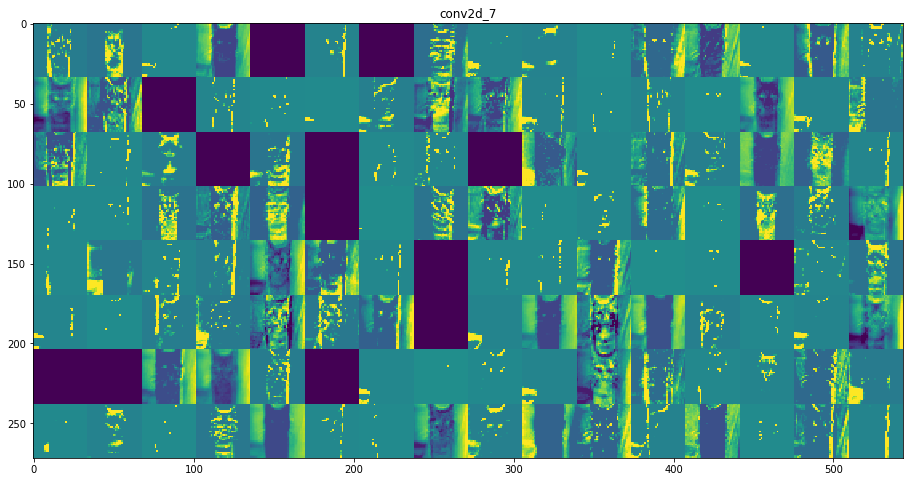

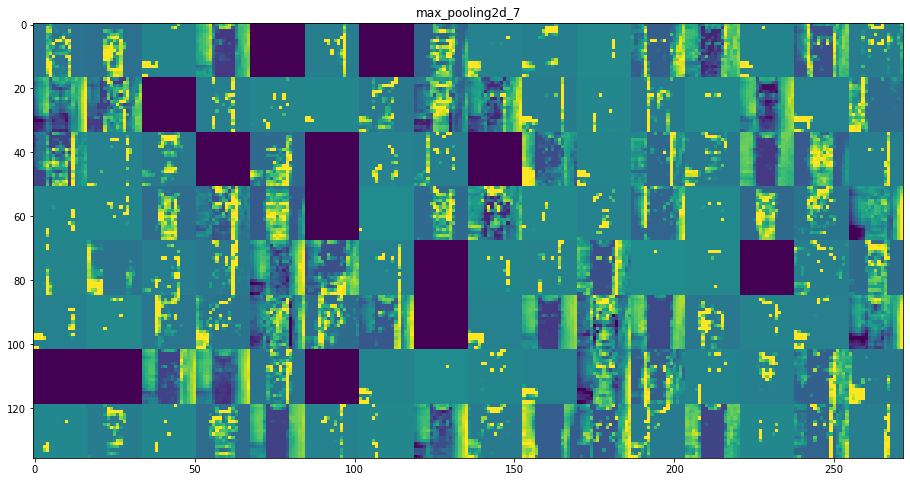

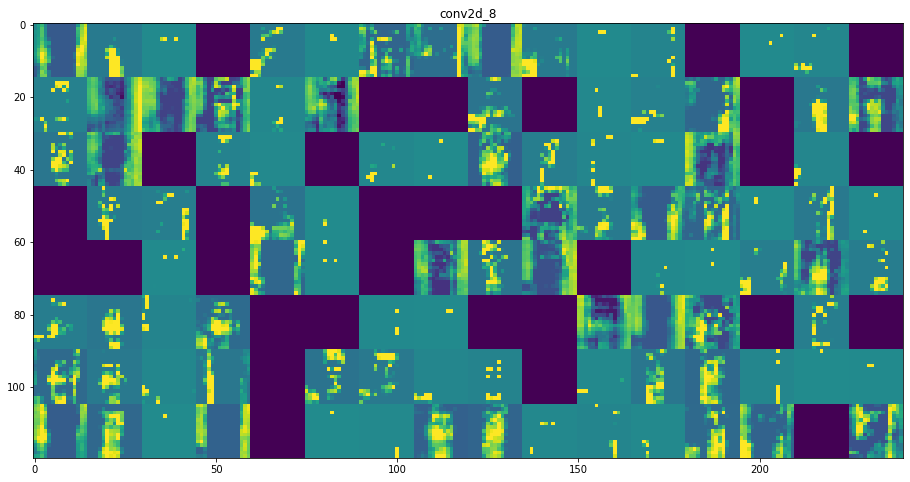

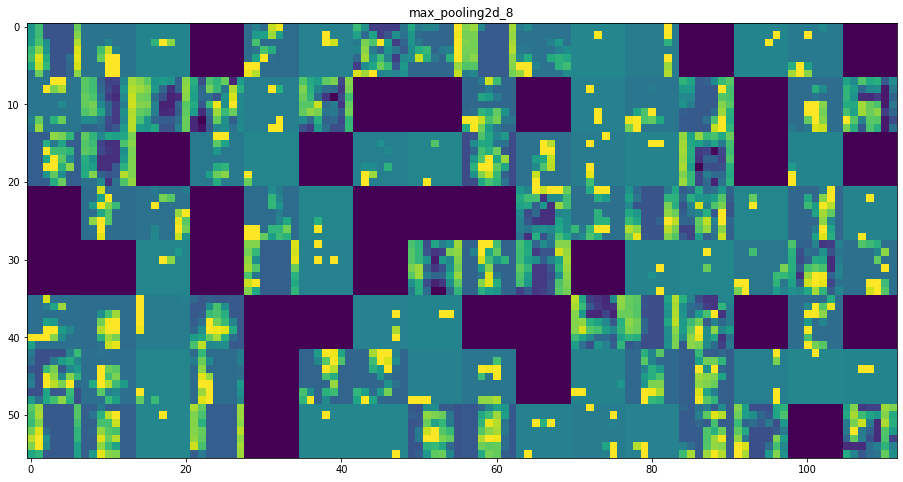

In [51]:
layers_names = []
for layer in model.layers[:8]:
    layers_names.append(layer.name) #Извлечение имен для их отображения на рисунке
images_per_row = 16
for layers_name, layers_activation in zip(layers_names, activations):
    n_features = layers_activation.shape[-1] #Количество каналов для данной карты
    size = layers_activation.shape[1]  #Размер карты
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, size * images_per_row))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layers_activation[0, :, :, col * images_per_row + row]
            
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') #limit value of array https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
            
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layers_name)
    plt.imshow(display_grid)
            

**Визуализация фильтров**

Идея - отобразить визуальный шаблон, за который отвечает каждый фильтр. <br>
Для этого используется метод градиентного восхождения в пространстве входов (gradient ascent in input space).<br>
Выполняется градиентный спуск до значения входного изображения нейронной сети, начав с пустого изображения. При этом максимизируется отклик конкретного фильтра.<br>
В результате получится изображение, для которого отклик фильтра был максимальным.

In [54]:
model = VGG16(weights = 'imagenet',
              include_top = False)

In [56]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


Рассмотрим единичный пример.

In [87]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output [:, :, :, filter_index]) #Функиця потерь, которая будет максимизировать значение данного фильтра данного сверточного слоя

In [88]:
grads = K.gradients(loss, model.input)[0]
#Проведем L2 нормализацию градиента для ускорения схождения
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #1e-5 - защита от деления на 0 

In [89]:
# iterate - принимает тензор numpy и возращает тензоры с loss и grad
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))]) #инициализация переменных

In [90]:
#Пример цикла, реализующего стохастический градиентный спуск
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128 #Начальное изображение - шум

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [91]:
def preprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

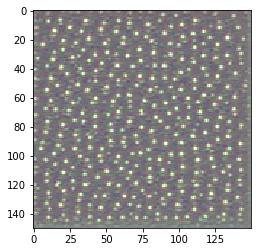

In [92]:
plt.imshow(preprocess_image(input_img_data[0]))

А теперь сведем все это в функцию

In [93]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return preprocess_image(img)

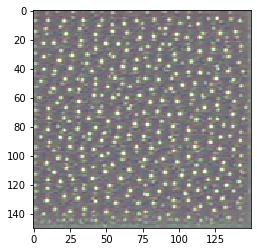

In [94]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

А теперь расширим пример на первые 64 фильтра в слое для первых слоев каждого сверточного блока

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


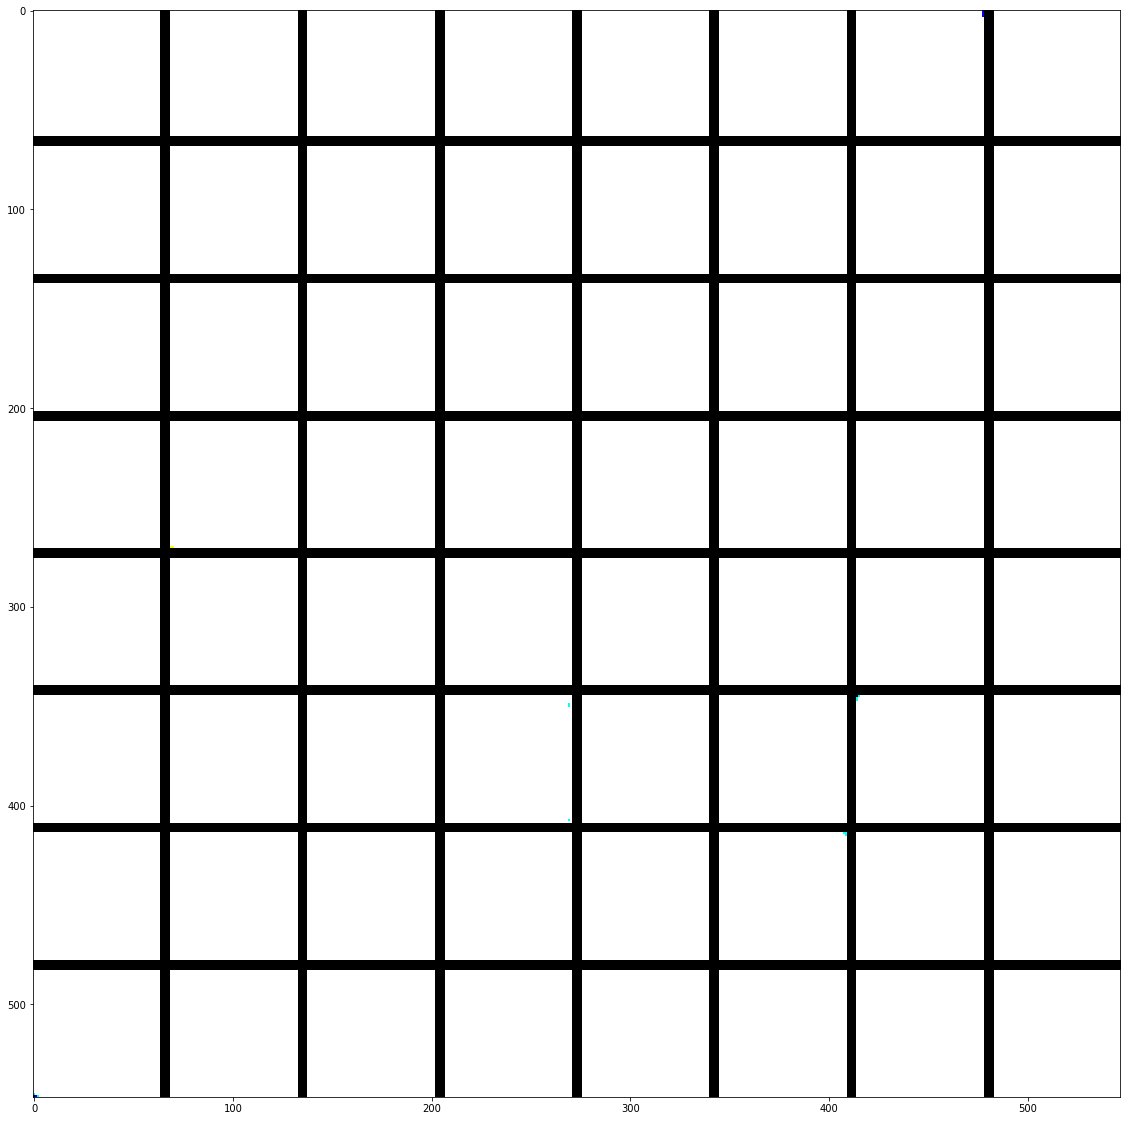

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


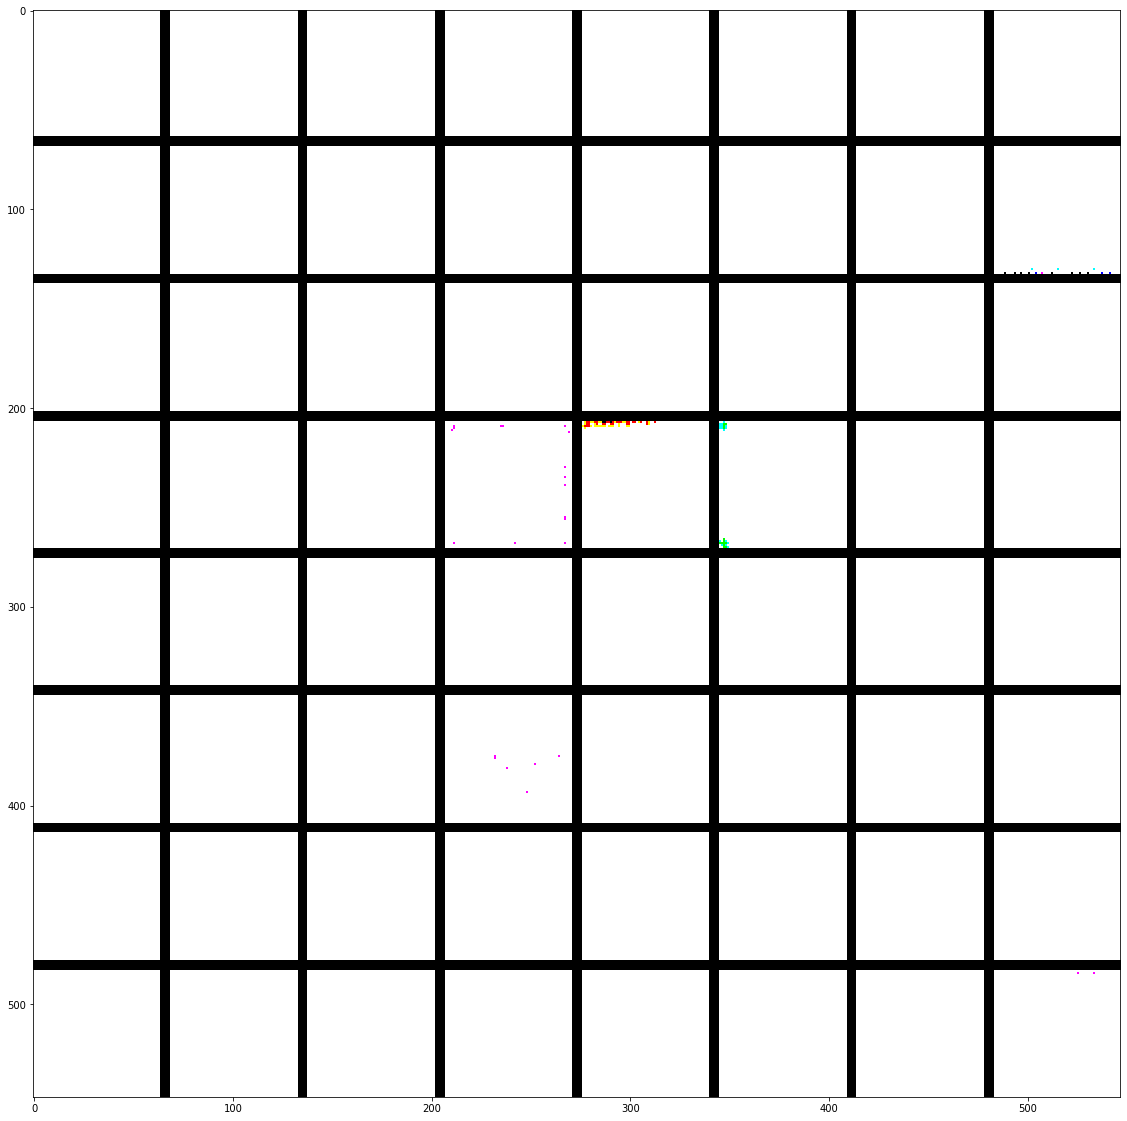

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


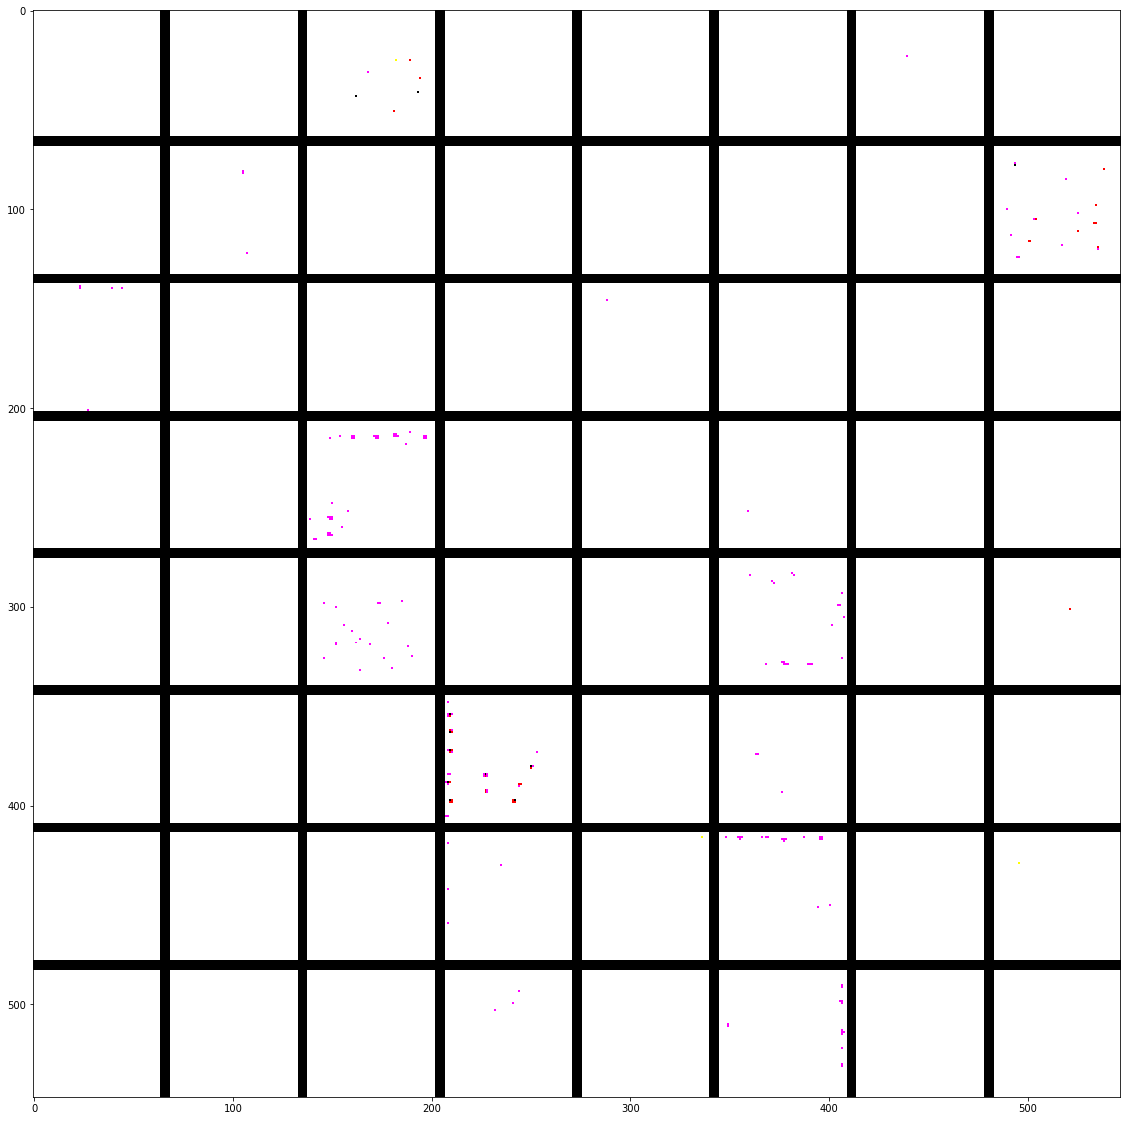

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


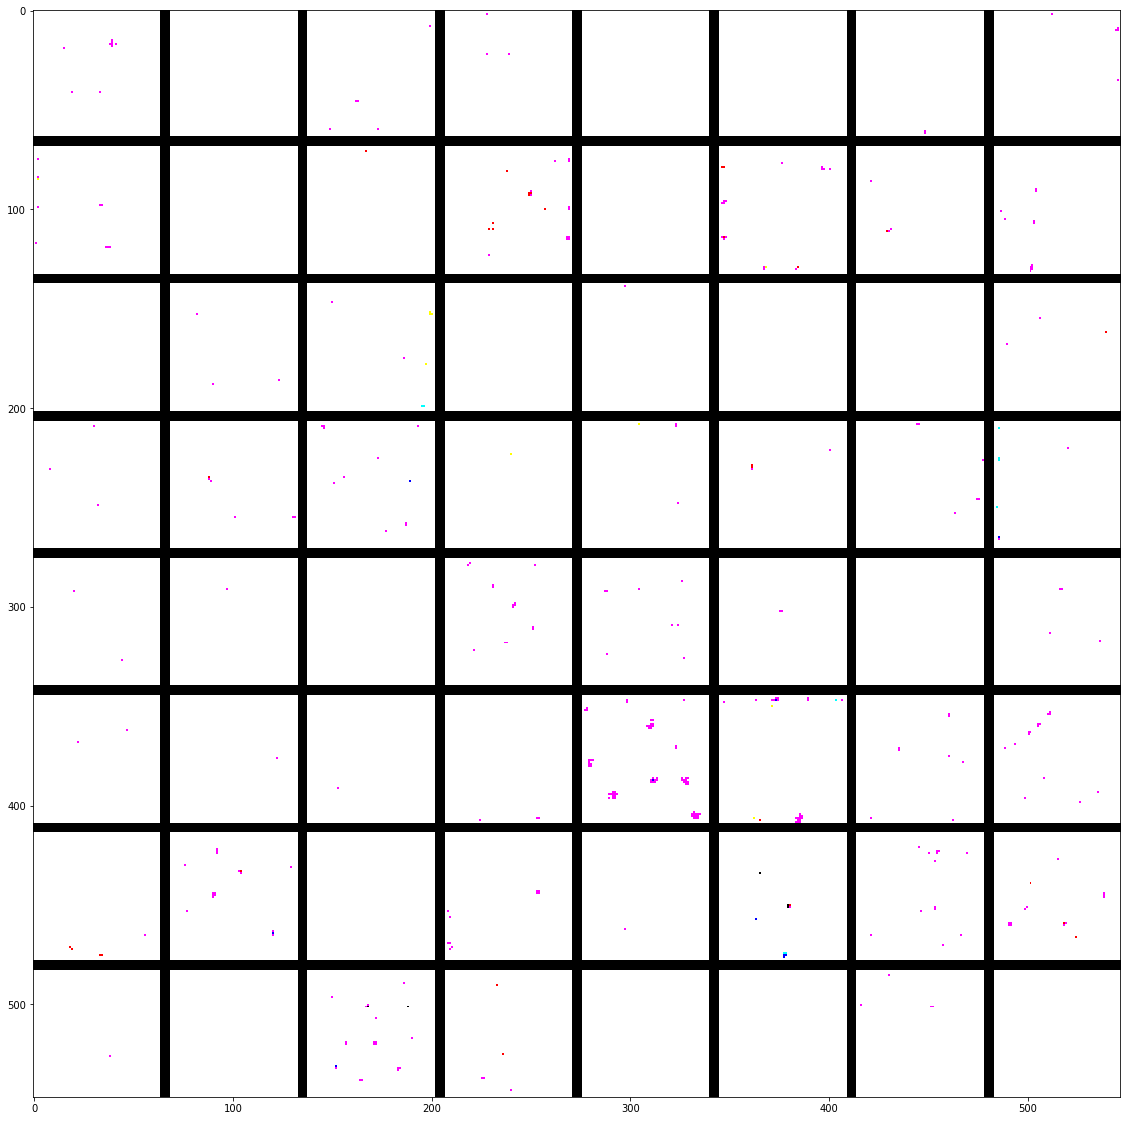

In [95]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

**Визуализация тепловых карт активации класса**

По мотивам статьи "Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization": https://arxiv.org/pdf/1610.02391.pdf

In [96]:
K.clear_session()

In [97]:
model = VGG16(weights = 'imagenet') #Скачиваем вместе с Dense слоями! Сразу видно насколько больше памяти заняла модель

553467904/553467096 [==============================] - 368s 1us/step


In [100]:
# Windows, home
img_path = r'H:\Datasets\elephants.jpg'

In [104]:
img = image.load_img(img_path, target_size = (224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x = preprocess_image(x) #preprocessing function from vgg16 API

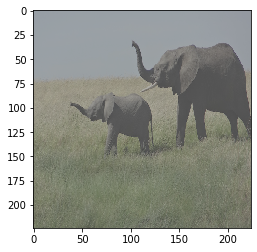

In [110]:
plt.imshow(x[0])

In [108]:
preds = model.predict(x)
print('Top 3 Predictions:', decode_predictions(preds, top = 3)[0])

40960/35363 [==================================] - 0s 0us/step
Top 3 Predictions: [('n02504458', 'African_elephant', 0.49559376), ('n01871265', 'tusker', 0.26105598), ('n02504013', 'Indian_elephant', 0.17652294)]


In [112]:
print('Index of most probable group:', np.argmax(preds[0]))

Index of most probable group: 386


In [113]:
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3') #Выходная карта признаков слоя block5_conv3 (последний сверточный слой VGG16)
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] #Градиент класса "Африканский слон" для block5_conv3

pooled_grads = K.mean(grads, axis = (0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i] #Умножаем каждый канал в слое на его "важность" для класса "африканский слон"
heatmap = np.mean(conv_layer_output_value, axis = -1)


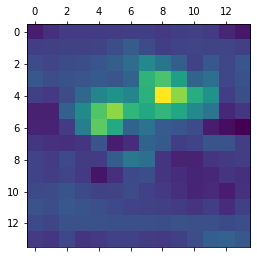

In [114]:
plt.matshow(heatmap)

In [ ]:
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) #Преаобразование тепловой карты в RGB формат

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
cv2.imshow('superimposed_img', superimposed_img)
